# This notebook is designed to assess functional differences between two groups of MAGs, eg those that belong to "treatment" and "control" groups. 

# To do this, we will take MAG-specific KO annotations for each group and identify genes that differ significantly between the two groups. 

# To run it, you will need KofamScan output files for each MAG, allocated to two directories according to group. You will also need the "master" KO file. Instructions for generating this file or downloading it are here: http://merenlab.org/2018/01/17/importing-ghostkoala-annotations/

In [1]:
import os as os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob as glob
from scipy import stats
import statsmodels
from statsmodels.stats.multitest import fdrcorrection


In [20]:
from statsmodels.stats.multitest import multipletests

### Function to import kofamscan outputs for each MAG, remove empty rows, and add a column with the MAG name

In [2]:
def make_mag_ko_matrix(file):
    a, b = file.split('.')
    c, d, e, f, g = a.split('_')
    name = c + '_' + d + '_' + e
    ko = pd.read_csv(file, sep='\t', names=['ORF', 'KO'])
    ko_mag = pd.DataFrame(ko['KO'])
    ko_mag.dropna(inplace=True)
    ko_mag['MAG'] = name
    return(ko_mag)

### Navigate to directory with first group of kofamscan outputs (eg MAGs in the "control" group).

In [3]:
os.chdir('/Users/npatin3/Desktop/GTPostdoc/Noro_Assemblies/mags/Group2_kofams')

### Loop through all kofamscan outputs and concatenate them into one file with MAG-specific column included

In [4]:
ko_mags_all2 = []
for file in glob.glob("*.txt"):
    x = make_mag_ko_matrix(file)
    ko_mags_all2.append(x)
    
ko_mags_all2 = pd.concat(ko_mags_all2)
ko_mags_all2.head()

,KO,MAG
2,K18929,36_12_003
3,K18928,36_12_003
4,K02469,36_12_003
8,K06113,36_12_003
10,K00208,36_12_003


### Reformat the data frame for the heat map

In [5]:
df2 = pd.pivot_table(data=ko_mags_all2, index='MAG',columns='KO',aggfunc=len).fillna(0)
df2.head()

KO,K00003,K00005,K00009,K00010,K00012,K00013,K00014,K00016,K00018,K00024,...,K23393,K23475,K23508,K23509,K23514,K23518,K23535,K23536,K23537,K23573
MAG,,,,,,,,,,,,,,,,,,,,,
13_1_001,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14_1_002,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15_1_010,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
15_1_014,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
15_1_015,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Drop all columns containing only zeros

In [6]:
df2 = df2.loc[:, (df2 != 0).any(axis=0)]

### If needed, go to a different directory and import the next group of MAG-specific kofams

In [7]:
os.chdir('/Users/npatin3/Desktop/GTPostdoc/Noro_Assemblies/mags/Group1_kofams')

### Now we can do the same process for the second group of MAGs ("treatment").

In [8]:
ko_mags_all1 = []
for file in glob.glob("*kofams.txt"):
    x = make_mag_ko_matrix(file)
    ko_mags_all1.append(x)
    
ko_mags_all1 = pd.concat(ko_mags_all1)
ko_mags_all1.head()

,KO,MAG
1,K07030,38_6_017
4,K00962,38_6_017
5,K02956,38_6_017
6,K03310,38_6_017
7,K07979,38_6_017


In [9]:
df1 = pd.pivot_table(data=ko_mags_all1, index='MAG',columns='KO',aggfunc=len).fillna(0)
df1.head()

KO,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23393,K23398,K23509,K23514,K23518,K23535,K23536,K23537,K23541,K23573
MAG,,,,,,,,,,,,,,,,,,,,,
15_3_004,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0
15_3_006,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
15_6_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15_6_011,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15_8_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Merge the two group ("treatment" vs "control") data frames

In [10]:
df_both = pd.concat([df1, df2]).fillna(0)
df_both.head()

,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23265,K23270,K23300,K23301,K23302,K23303,K23349,K23356,K23475,K23508
MAG,,,,,,,,,,,,,,,,,,,,,
15_3_004,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15_3_006,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15_6_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15_6_011,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15_8_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Optional: to generate a presence/absence matrix

In [274]:
df_both_presabs = df_both.astype(bool).astype(int)

In [11]:
df_both.to_csv("MAG_KOs_bothgroups.csv")

## Calculate fold change and run t-tests on genes in increase MAGs / decrease MAGs 

### Add two new rows for statistical results

In [16]:
df_ttest = df_both.append(pd.Series(name='ttest'))
df_ttest = df_ttest.append(pd.Series(name='p-value'))
df_ttest = df_ttest.append(pd.Series(name='corrected_p-value'))
df_ttest.tail()

/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23265,K23270,K23300,K23301,K23302,K23303,K23349,K23356,K23475,K23508
MAG,,,,,,,,,,,,,,,,,,,,,
4_1_004,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4_4_014,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ttest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p-value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
corrected_p-value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fill new rows with results of scipy t-tests

In [102]:
df_ttest.iloc[39] = np.array(stats.ttest_ind(df_ttest.iloc[:13, :], df_ttest.iloc[13:39, :], axis=0, equal_var=False))[0]
df_ttest.iloc[40] = np.array(stats.ttest_ind(df_ttest.iloc[:13, :], df_ttest.iloc[13:39, :], axis=0, equal_var=False))[1]
df_ttest.iloc[41] = multipletests(df_ttest.iloc[40], alpha=0.1, method='bonferroni')[1]
df_ttest.tail()

/Users/npatin3/miniconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/npatin3/miniconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/npatin3/miniconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/npatin3/miniconda/lib/python3.6/site-packages/statsmodels/stats/multitest.py:147: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphacBonf
/Users/npatin3/miniconda/lib/python3.6/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23265,K23270,K23300,K23301,K23302,K23303,K23349,K23356,K23475,K23508
MAG,,,,,,,,,,,,,,,,,,,,,
4_4_014,1.000000,1.000000,1.000000e-09,1.000000,1.000000e-09,1.000000,1.000000,1.000000e-09,1.000000,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
ttest,1.334686,0.881591,-2.897914e+00,-3.337119,1.471225e-01,-0.239732,-2.002474,1.477098e+00,0.899843,-2.480695e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.443376e+00,-1.000000e+00,-1.000000e+00,-1.443376e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
p-value,0.194754,0.392357,6.439777e-03,0.002820,8.850683e-01,0.812238,0.055083,1.654067e-01,0.377901,1.786701e-02,...,3.268919e-01,3.268919e-01,3.268919e-01,1.613294e-01,3.268919e-01,3.268919e-01,1.613294e-01,3.268919e-01,3.268919e-01,3.268919e-01
corrected_p-value,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
fold change,1.538462,3.000000,1.904762e-01,0.363636,1.047619e+00,0.857143,0.470588,1.538462e+08,1.500000,2.000000e-01,...,2.600000e-08,2.600000e-08,2.600000e-08,1.300000e-08,2.600000e-08,2.600000e-08,1.300000e-08,2.600000e-08,2.600000e-08,2.600000e-08


### Function to calculate fold difference between asymptomatic and symptomatic samples

In [33]:
def fold_difference(df, num_symp_rows, num_sample_rows):
    set1 = df.iloc[0:num_symp_rows]
    set2 = df.iloc[num_symp_rows:num_sample_rows]
    mean_diff = np.mean(set1) / np.mean(set2)
    #print(mean_diff)
    return(mean_diff)

### Apply function to data frame to calculate fold difference of each column

In [34]:
df_ttest = df_ttest.replace(0, 0.000000001)
df_ttest.loc['fold change'] = fold_difference(df_ttest, 13, 39)
df_ttest.head()

,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23265,K23270,K23300,K23301,K23302,K23303,K23349,K23356,K23475,K23508
MAG,,,,,,,,,,,,,,,,,,,,,
15_3_004,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e+00,1.000000e+00,1.000000e-09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_3_006,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e-09,1.000000e+00,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_6_004,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_6_011,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_8_002,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09


### Select only KOs that are significantly different between the groups, with a corrected p-value < 0.05

In [103]:
df_ttest.tail()

,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23265,K23270,K23300,K23301,K23302,K23303,K23349,K23356,K23475,K23508
MAG,,,,,,,,,,,,,,,,,,,,,
4_4_014,1.000000,1.000000,1.000000e-09,1.000000,1.000000e-09,1.000000,1.000000,1.000000e-09,1.000000,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
ttest,1.334686,0.881591,-2.897914e+00,-3.337119,1.471225e-01,-0.239732,-2.002474,1.477098e+00,0.899843,-2.480695e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.443376e+00,-1.000000e+00,-1.000000e+00,-1.443376e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
p-value,0.194754,0.392357,6.439777e-03,0.002820,8.850683e-01,0.812238,0.055083,1.654067e-01,0.377901,1.786701e-02,...,3.268919e-01,3.268919e-01,3.268919e-01,1.613294e-01,3.268919e-01,3.268919e-01,1.613294e-01,3.268919e-01,3.268919e-01,3.268919e-01
corrected_p-value,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
fold change,1.538462,3.000000,1.904762e-01,0.363636,1.047619e+00,0.857143,0.470588,1.538462e+08,1.500000,2.000000e-01,...,2.600000e-08,2.600000e-08,2.600000e-08,1.300000e-08,2.600000e-08,2.600000e-08,1.300000e-08,2.600000e-08,2.600000e-08,2.600000e-08


In [104]:
kos_signif = df_ttest.loc[:, df_ttest.loc['corrected_p-value'] < 0.05]
kos_signif.shape

(43, 15)

In [105]:
kos_signif.tail()

,K04070,K05896,K06346,K06960,K09762,K09787,K11145,K14540,K00348,K00721,K02426,K02536,K07405,K09810,K11085
MAG,,,,,,,,,,,,,,,
4_4_014,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
ttest,6.324555,5.838742,5.494423,5.838742,5.581563,5.838742,6.324555,7.500000e+00,-5.400617e+00,-5.400617e+00,-5.400617e+00,-5.400617e+00,-5.400617e+00,-5.838742e+00,-5.838742e+00
p-value,0.000001,0.000004,0.000010,0.000004,0.000002,0.000004,0.000001,7.465183e-08,1.326636e-05,1.326636e-05,1.326636e-05,1.326636e-05,1.326636e-05,4.336874e-06,4.336874e-06
corrected_p-value,0.004668,0.015812,0.038026,0.015812,0.008881,0.015812,0.004668,2.721806e-04,4.836914e-02,4.836914e-02,4.836914e-02,4.836914e-02,4.836914e-02,1.581224e-02,1.581224e-02
fold change,2.600000,2.363636,2.600000,2.363636,2.800000,2.363636,2.600000,3.250000e+00,1.857143e-09,1.857143e-09,1.857143e-09,1.857143e-09,1.857143e-09,1.733333e-09,1.733333e-09


### Save this matrix of KOs to a file

In [40]:
kos_signif.to_csv("MAG_SDKOs_CORRECTED_p05.csv")

### Save just the list of significantly different KOs

In [41]:
ko_sd_list = list(kos_signif.columns)

In [42]:
with open("MAG_SDKOs_CORRECTED_p05.txt", "w") as output:
    output.write(str(ko_sd_list))

# Get annotations of significantly different KOs

### Import the "master" KO htext file

In [43]:
ko_master = '/Users/npatin3/Desktop/GTPostdoc/Noro_Assemblies/KO_Orthology_ko00001.txt'

### Match the KO number in column 3 of the master file with the KO list

In [44]:
# KO list
kos_unfilt = df_both.columns.to_list()

In [56]:
with open(ko_master, 'r') as file, open('MAG_KOs_fxns_unfilt.tsv', 'w') as outfile:
    for line in file:
        X = line.rstrip().split('\t')
        konumber = X[3].split(' ')[0]
        if konumber in kos_unfilt:
            outfile.write(line)

In [57]:
kos = pd.read_csv('MAG_KOs_fxns_unfilt.tsv', names=['Group','Subgroup1','Subgroup2','KO'], sep='\t')
kos.head()

,Group,Subgroup1,Subgroup2,KO
0,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00844 HK; hexokinase [EC:2.7.1.1]
1,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00845 glk; glucokinase [EC:2.7.1.2]
2,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],"K01810 GPI, pgi; glucose-6-phosphate isomeras..."
3,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],"K06859 pgi1; glucose-6-phosphate isomerase, a..."
4,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],"K00850 pfkA, PFK; 6-phosphofructokinase 1 [EC..."


In [58]:
kos.shape

(6198, 4)

### Exclude all irrelevant KEGG categories

In [59]:
searchfor = ['Human Diseases','Brite Hierarchies','Organismal Systems',
                                    'Cellular community - eukaryotes']
kos2 = kos.loc[~kos['Group'].str.contains('|'.join(searchfor))]

### Sanity check - kos2 should be much smaller than kos

In [60]:
kos2.shape

(3816, 4)

### Reformat the data frame text to make it more readable

In [61]:
# Split the function from the KO
kos2[['KO', 'Function']] = kos2['KO'].str.split(" ", n=1, expand=True)
#kos2 = kos.drop('PATH', axis=1)
kos2.head()

/Users/npatin3/miniconda/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Group,Subgroup1,Subgroup2,KO,Function
0,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00844,HK; hexokinase [EC:2.7.1.1]
1,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00845,glk; glucokinase [EC:2.7.1.2]
2,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K01810,"GPI, pgi; glucose-6-phosphate isomerase [EC:5..."
3,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K06859,"pgi1; glucose-6-phosphate isomerase, archaeal..."
4,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00850,"pfkA, PFK; 6-phosphofructokinase 1 [EC:2.7.1.11]"


In [62]:
# Split out the "PATH" part of Subgroup2 label
kos2[['Subgroup2', 'PATH']] = kos2['Subgroup2'].str.split("[", n=1, expand=True)
kos2 = kos2.drop('PATH', axis=1)
kos2 = kos2.drop_duplicates(subset=['KO'])
kos2.head()

/Users/npatin3/miniconda/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Group,Subgroup1,Subgroup2,KO,Function
0,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K00844,HK; hexokinase [EC:2.7.1.1]
1,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K00845,glk; glucokinase [EC:2.7.1.2]
2,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K01810,"GPI, pgi; glucose-6-phosphate isomerase [EC:5..."
3,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K06859,"pgi1; glucose-6-phosphate isomerase, archaeal..."
4,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K00850,"pfkA, PFK; 6-phosphofructokinase 1 [EC:2.7.1.11]"


### Select only the KOs that are significantly different (listed earlier in ko_sd_list)

In [68]:
kos_funct = kos2.loc[kos2['KO'].isin(ko_sd_list), :]

In [64]:
kos_funct = kos_funct[['KO','Function']].to_csv('MAG_KOs_SD_CORRECTED_functions.csv')

## Format for heat map

### Exclude the last two rows (p-value and t-test results)

In [65]:
df_hmap = kos_signif.iloc[0:39, ]

### Need to use list of KOs from 'kos_funct' because it excluded the irrelevant categories

In [70]:
final_ko_list = kos_funct.KO

In [71]:
df_hmap = df_hmap[df_hmap.columns.intersection(final_ko_list)]
df_hmap.head()

,K04070,K06346,K06960,K09762,K09787,K00348,K00721,K02426,K02536,K07405,K09810,K11085
MAG,,,,,,,,,,,,
15_3_004,1.0,1.0,1.0,1.0,1.0,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_3_006,1.0,1.0,1.0,1.0,1.0,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_6_004,1.0,1.0,1.0,1.0,1.0,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_6_011,1.0,1.0,1.0,1.0,1.0,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_8_002,1.0,1.0,1.0,1.0,1.0,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09


In [72]:
# Square root transform if necessary
df_hmap_sqrt = np.sqrt(df_hmap.replace(0, 0.00000000001))

## Set palettes for color bars

### 1. MAG colors (increase vs decrease)

#### Use information about your samples to assing colors to each sample according to its group

In [73]:
mags1 = pd.DataFrame(ko_mags_all1['MAG']).drop_duplicates(subset=['MAG'])
mags2 = pd.DataFrame(ko_mags_all2['MAG']).drop_duplicates(subset=['MAG'])
mags1['Group'] = 'darkblue'
mags2['Group'] = 'orange'
sample_colors = pd.concat([mags1, mags2]).set_index('MAG')

## 2. Gene colors (by functional group)

In [74]:
kos_column_colors = kos_funct[['Group', 'KO']]
kos_column_colors.shape

(12, 2)

In [75]:
kos_column_colors = kos_funct[['Group', 'KO']]
kos_column_colors[['Group', 'Functional category']] = kos_column_colors['Group'].str.split(" ", n=1, expand=True)
kos_column_colors = kos_column_colors.drop('Group', axis=1)
kos_column_colors.head()

/Users/npatin3/miniconda/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,KO,Functional category
298,K07405,Metabolism
1520,K00721,Metabolism
1540,K02536,Metabolism
2435,K09810,Environmental Information Processing
2448,K11085,Environmental Information Processing


In [76]:
kos_column_colors['Functional category'].unique()

array(['Metabolism', 'Environmental Information Processing',
       'Not Included in Pathway or Brite'], dtype=object)

In [77]:
lut = dict(zip(kos_column_colors['Functional category'].unique(), 
                sns.color_palette("Paired")))
lut

{'Metabolism': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Environmental Information Processing': (0.12156862745098039,
  0.47058823529411764,
  0.7058823529411765),
 'Not Included in Pathway or Brite': (0.6980392156862745,
  0.8745098039215686,
  0.5411764705882353)}

In [78]:
kos_column_colors['Color'] = kos_column_colors['Functional category'].map(lut)
kos_column_colors.head()

,KO,Functional category,Color
298,K07405,Metabolism,"(0.6509803921568628, 0.807843137254902, 0.8901..."
1520,K00721,Metabolism,"(0.6509803921568628, 0.807843137254902, 0.8901..."
1540,K02536,Metabolism,"(0.6509803921568628, 0.807843137254902, 0.8901..."
2435,K09810,Environmental Information Processing,"(0.12156862745098039, 0.47058823529411764, 0.7..."
2448,K11085,Environmental Information Processing,"(0.12156862745098039, 0.47058823529411764, 0.7..."


In [79]:
lut3 = dict(zip(kos_column_colors['KO'], kos_column_colors['Color']))
column_colors = pd.Series(lut3)

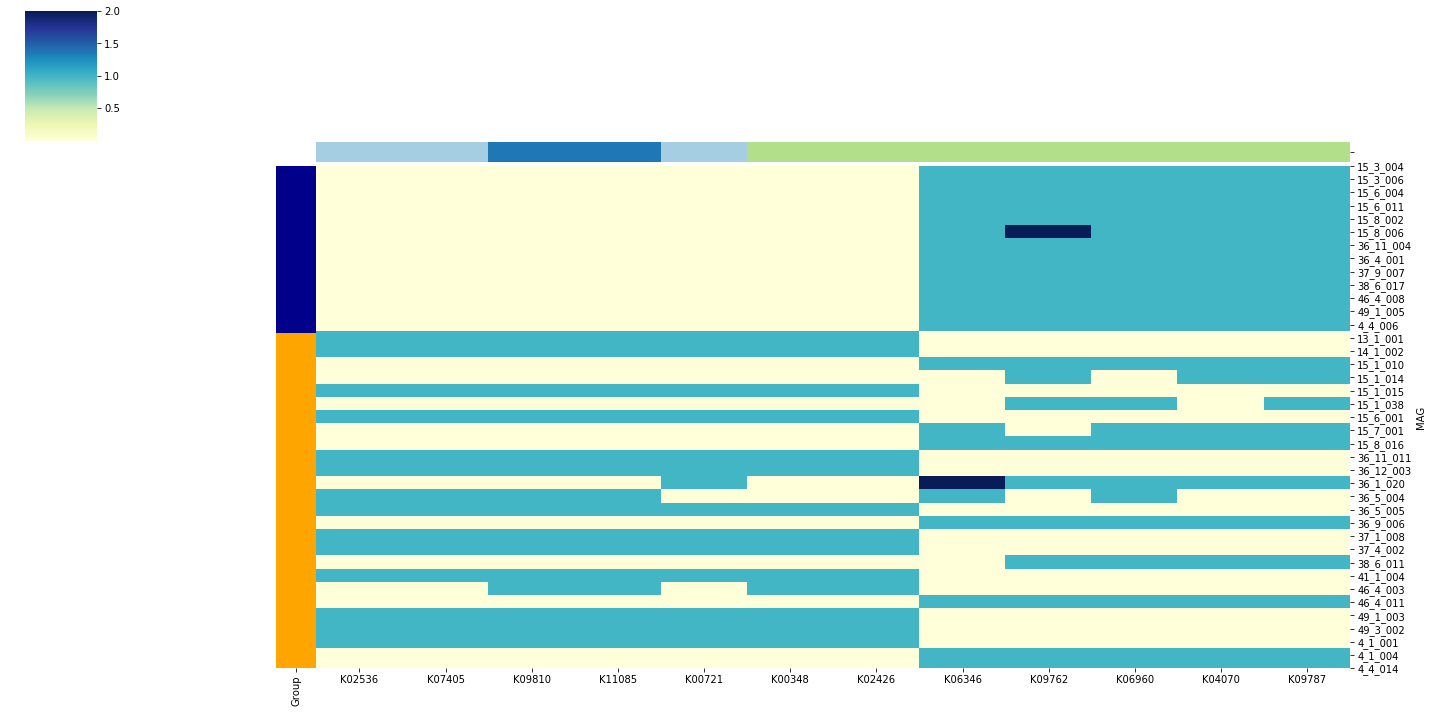

In [83]:
# Quick and dirty to check
p = sns.clustermap(df_hmap, cmap='YlGnBu', figsize=(20,10), xticklabels=True, yticklabels=True,
                   row_cluster=False, method='ward', metric='euclidean', row_colors=sample_colors, 
                   col_colors=column_colors)
p.ax_col_dendrogram.set_visible(False)

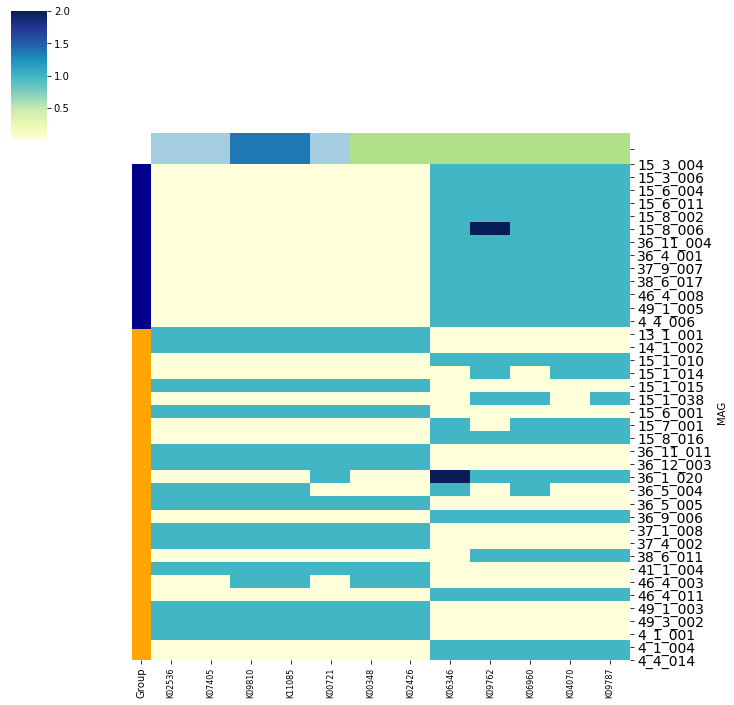

In [100]:
# Make it look pretty
# See below for sample_colors and column_colors
p = sns.clustermap(df_hmap, cmap='YlGnBu', xticklabels=True, yticklabels=True, row_cluster=False,
                   method='ward', metric='euclidean', row_colors=sample_colors, col_colors=column_colors
                  ) # linewidths=0.1
hm = p.ax_heatmap.get_position()
plt.setp(p.ax_heatmap.yaxis.get_majorticklabels(), fontsize=14)
plt.setp(p.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8)
p.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height])
col = p.ax_col_dendrogram.get_position()
row = p.ax_row_dendrogram.get_position()
p.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height])
p.ax_col_colors.set_position([col.x0, col.y0-0.04, col.width, col.height*0.25])
#p.ax_row_dendrogram.set_position([row.x0+0.07, row.y0, row.width*0.75, row.height])
p.ax_col_dendrogram.set_visible(False)

In [101]:
p.savefig("MAGs_KOs_clustermap_SDCORRECTEDp05_labels.png")

### Custom legend

In [346]:
%matplotlib inline

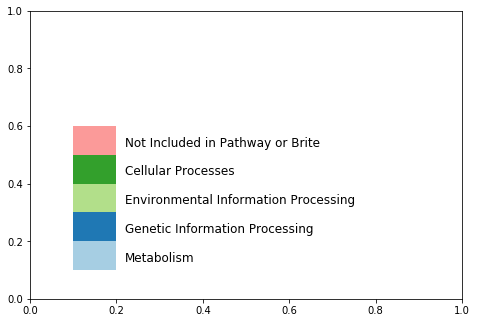

In [218]:
x, y = (0.1, 0)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for func in kos_column_colors['Functional category'].unique():
    y = y + 0.1
    color = lut[func]
    #cat = lut3[ko]
    square = plt.Rectangle((x, y), 0.1, 0.1, fc=color)
    plt.gca().add_patch(square)
    plt.text(x + 0.12, y + 0.03, func, fontsize=12)

In [219]:
fig.savefig('fxn_labels.png')